In [66]:
import nltk


nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/munyoki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/munyoki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/munyoki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# News Dataset



How does our dataset look like?

In [51]:
import pandas as pd

news_df = pd.read_csv("bbc-news-data.csv", sep="\t")
news_df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [48]:
news_df.shape

(2225, 4)

In [52]:
news_df["category"].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [58]:
news_df["category"] = news_df["category"].replace("tech", "technology")

In [59]:
news_df["category"].uniqueque()

array(['business', 'entertainment', 'politics', 'sport', 'technology'],
      dtype=object)

<Axes: ylabel='category'>

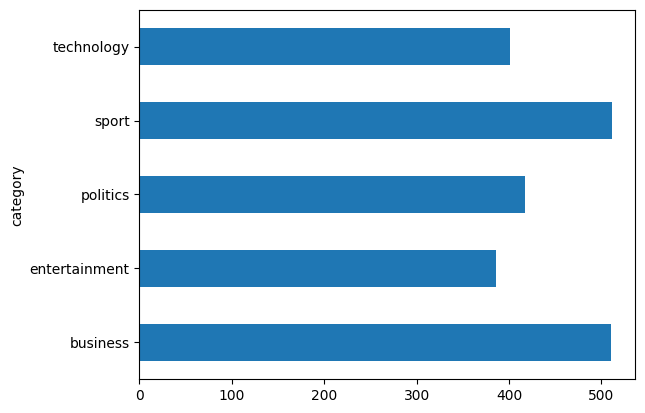

In [60]:
import matplotlib.pyplot as plt
news_df.groupby(['category']).size().plot.barh(x="category")

In [69]:
stop_words = set(stopwords.words("english")) | STOPWORDS

def plot_wordcloud(name):
    _df = news_df[news_df["category"] == name]
    return WordCloud(width=800, height=400,
                     stopwords=stop_words).generate(" ".join(_df["title"]))

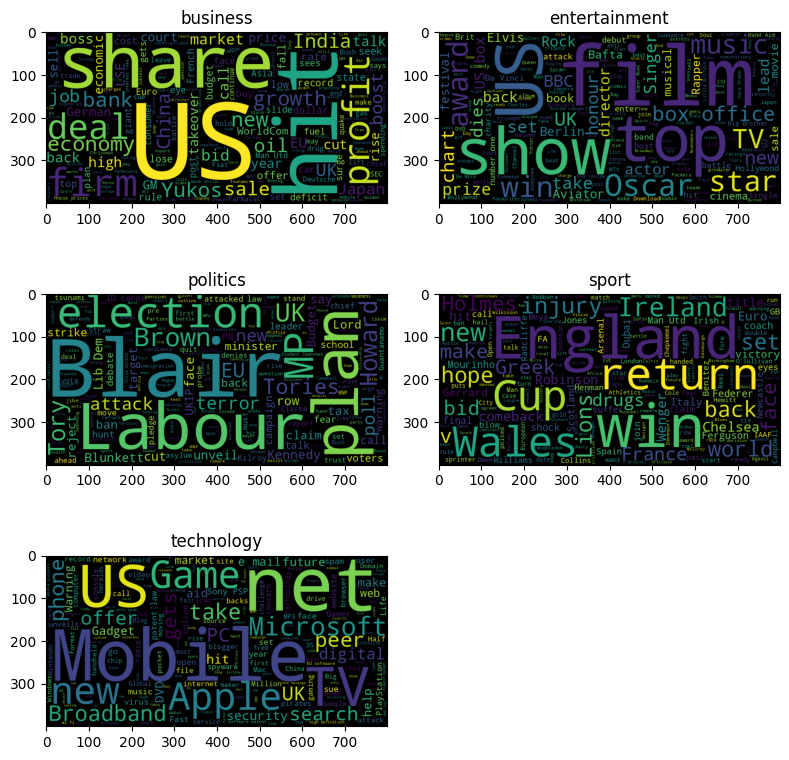

In [70]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

fig = plt.figure(figsize=(8, 8))

for i, name in enumerate(news_df["category"].unique().tolist()):    
    ax = fig.add_subplot(3, 2, i+1).set_title(name)
    plt.imshow(plot_wordcloud(name))
fig.tight_layout()
plt.show()

## NLP Processing

### Clean data

In [71]:
import re
import spacy

nlp = spacy.load('en_core_web_lg')


In [72]:
def clean_data(document, stop_words):
    """Remove STOP_WORDS, symbols and non-ascii characters
    from the DOCUMENT and lemmatize the result."""
    document = re.sub( "[^a-zA-Z]", " ", document)
    document = document.lower()
    document = re.sub("&lt;/?.*?&gt;",
                      " &lt;&gt; ",
                      document)
    document = " ".join(word for word in document.split(" ") if word not in stop_words)
    document = " ".join(token.lemma_ for token in nlp(document))
    return " ".join(document.split())
    

# Example
test_document = clean_data(news_df["title"].iloc(0)[0], stop_words)
test_document

'ad sale boost time warner profit'

### Extracting key-words from a document - TF-IDF

In [73]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import coo_matrix


def extract_top_n_feature_names(document, top_n):
    """Use TF-IDF (term frequency/inverse document frequency) to extract
  keywords from a DOCUMENT.  TF-IDF lists word frequency scores
  that highlight words that are more important to the context rather
  than those that appear frequently across documents"""
    def sort_coo(coo_matrix):
        return sorted(zip(coo_matrix.col, coo_matrix.data),
                     key=lambda x: (x[1], x[0]),
                     reverse=True)

    def extract_top_n_from_vector(feature_names, sorted_items, top_n):
        score_vals, feature_vals, results = [], [], {}
        for idx, score in sorted_items[0:top_n]:
            list.append(score_vals, round(score, 3))
            list.append(feature_vals, feature_names[idx])
        for idx in range(len(feature_vals)):
            results[feature_vals[idx]] = score_vals[idx]
        return results
    
    count_vect = CountVectorizer()
    X = count_vect.fit_transform([document])
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    feature_names = count_vect.get_feature_names_out()
    tfidf_transformer.fit(X)
    tfidf_transformer.transform(count_vect.transform([document]))
    tfidf_vector = tfidf_transformer.transform(count_vect.transform([document]))
    return extract_top_n_from_vector(feature_names,
                                    sort_coo(tfidf_vector.tocoo()),
                                    top_n)

In [87]:
feature_names = extract_top_n_feature_names(test_document, 3)

### Get Labels

In [75]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy import spatial


def embed(tokens, model):
    """Return the centroid of the embeddings that correspond to the
  provided TOKENS give some language MODEL.  Any tokens that are
  out-of-vocabulary will not be considered, and stopwords will also be
  excluded. If none of the tokens are valid, the function will return
  an array of zeros."""
    lexemes = (model.vocab[token] for token in tokens)
    vectors = np.asarray([lexeme.vector for lexeme in lexemes
                          if lexeme.has_vector and (not lexeme.is_stop)
                          and (len(lexeme.text) > 1)])
    return vectors.mean(axis=0) if len(vectors) > 0 else np.zeros(model.meta['vectors']['width'])


def centroid_to_label(centroid, labels, model):
    """Return the closest label listed in LABELS from the CENTROID and
  MODEL"""
    label_vectors = np.asarray([embed(label.split(), model) for label in labels])
    closest_neighbor = NearestNeighbors(n_neighbors=1, metric=spatial.distance.cosine)
    closest_neighbor.fit(label_vectors)
    closest_label = closest_neighbor.kneighbors([centroid], return_distance=False)
    return labels[closest_label[0][0]]

In [76]:
centroid = embed(test_document.split(), nlp)
centroid

array([ 0.662625  ,  1.5726833 , -2.167935  ,  2.9309785 ,  3.6041381 ,
       -0.74658996,  2.1842766 ,  1.5700498 , -2.208882  , -1.7505517 ,
        2.1212683 ,  1.7766749 , -3.4979837 ,  2.1039336 , -4.5628667 ,
        2.1759765 ,  2.1158984 ,  0.01134829,  2.2105167 ,  1.5795435 ,
       -0.10134169,  1.2980983 , -4.9653945 ,  0.6339316 ,  0.0872283 ,
       -1.3430117 , -0.7165683 ,  0.38520333, -1.6345533 ,  2.30155   ,
        1.6248199 ,  2.5001833 , -2.71261   , -0.42575333,  2.4784915 ,
       -0.7019734 ,  1.6240683 ,  0.8143149 ,  1.0185968 ,  2.4475052 ,
       -0.663181  ,  1.3165241 ,  2.3968    ,  0.10432871, -3.8496666 ,
        1.9529167 ,  2.8565502 , -3.7116468 ,  3.0230167 , -1.3870567 ,
        1.8798884 , -0.87778074, -1.1122016 , -2.6856499 , -3.1300638 ,
        0.567475  , -1.5212599 ,  0.10787002,  1.6196917 , -0.47108665,
        3.0129204 ,  0.66753834,  0.98258835, -3.2568817 ,  3.43645   ,
        1.577705  , -4.3765163 , -1.2031549 , -1.5569267 ,  2.69

In [78]:
labels = news_df["category"].unique().tolist()
labels

['business', 'entertainment', 'politics', 'sport', 'technology']

### Performance

In [121]:
def predict(doc, labels):
    doc = clean_data(doc, stop_words)
    doc = " ".join(extract_top_n_feature_names(doc, 20).keys())
    centroid = embed(doc.split(), nlp)
    return centroid_to_label(centroid=centroid, labels=labels, model=nlp)

predict("this is an artsy thing", labels)

'entertainment'

This takes quite some time to run!

In [122]:
predicted_df = news_df.copy()
predicted_df["predicted"] = (predicted_df["title"] + predicted_df["content"]).apply(lambda x: predict(x, labels))
predicted_df.head()

,category,filename,title,content,predicted
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,business
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,business
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,business
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,business
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,business


In [123]:
from sklearn import metrics

report = metrics.classification_report(
    y_true=predicted_df["category"],
    y_pred=predicted_df["predicted"],
    labels=labels
)
print(report)

               precision    recall  f1-score   support

     business       0.52      0.95      0.67       510
entertainment       0.74      0.87      0.80       386
     politics       0.91      0.34      0.50       417
        sport       0.91      0.85      0.88       511
   technology       0.90      0.43      0.58       401

     accuracy                           0.71      2225
    macro avg       0.79      0.69      0.69      2225
 weighted avg       0.79      0.71      0.69      2225

